# Logistic Regression Experiment

Andrew McDonald // CSE 847 // 29 March 2021

In this experiment, we implement two variants of a logistic regression classifier: in part 1, we implement an unregularized model, and in part 2, we implement an $\ell_1$ regularized model for sparse learning.

We recall that the logistic regression model $f: \mathbb{R}^d \rightarrow [0, 1]$ makes predictions by

\begin{align}
\hat{y} = \sigma({\bf w}^{\top}{\bf x}), \quad \text{where} \quad \sigma(z) = \frac{1}{1 + e^z},
\end{align}

and note that we may prepend an entry of 1 to each vector ${\bf x}$ to incorporate a bias in the linear term ${\bf{w}}^{\top}{\bf{x}}$. Throughout, we take $y \in \{ 0, 1\}$ as our binary target encoding.

#### Experiment 1: Unregularized Logistic Regression
In part 1, we use gradient descent to find the optimal weight vector $\bf{w}$ which minimizes the unregularized cross-entropy loss

\begin{align}
\mathcal{L} = -\frac{1}{N} \left[ \sum_{i=1}^N y_i \log \sigma({\bf w}^{\top}{\bf x}_i) + (1-y_i) \log(1 - \sigma({\bf w}^{\top}{\bf x}_i)) \right].
\end{align}

This loss can be derived as the negative log-likelihood of a Bernoulli distribution with iid samples, as is done in the supplementary logistic regression notes provided on D2L.

The gradient of this loss (also computed in the supplementary logistic regression notes) is given by

\begin{align}
\nabla_{\bf w}\mathcal{L} = \frac{1}{N} \left[ \sum_{i=1}^N (\sigma({\bf w}^{\top}{\bf x}_i) - y_i) {\bf x}_i \right].
\end{align}

#### Experiment 2: Sparse Logistic Regression
Similarly, in part 2, we use subgradient descent to find the ${\bf w}$ which minimizes the $\ell_1$ cross-entropy loss

\begin{align}
\mathcal{L} = -\frac{1}{N} \left[ \sum_{i=1}^N y_i \log \sigma({\bf w}^{\top}{\bf x}_i) + (1-y_i) \log(1 - \sigma({\bf w}^{\top}{\bf x}_i)) \right] + \lambda \| {\bf w} \|_1.
\end{align}

Again, this loss has a negative log-likelihood interpretation with respect to a Bernoulli distribution, with an added regularization term. The subgradient of the $\ell_1$ regularized loss is given by

\begin{align}
\nabla_{\bf w}\mathcal{L} = \frac{1}{N} \left[ \sum_{i=1}^N (\sigma({\bf w}^{\top}{\bf x}_i) - y_i) {\bf x}_i \right] + \lambda \; \text{sign}({\bf w})
\end{align}

where the sign operator is defined elementwise on ${\bf w}$ by

\begin{align}
\text{sign}(w_i) = \begin{cases}
    +1 & w_i > \lambda \\
    -1 & w_i < -\lambda \\
    0 & \text{otherwise.}
\end{cases}
\end{align}

#### Gradient Descent
We may optimize ${\bf w}$ to a global minimum using gradient descent due to the convexity of each loss function. Specifically, we iteratively update

\begin{align}
{\bf w}^{(t+1)} \leftarrow {\bf w}^{(t)} - \eta \nabla_{\bf w}^{(t)} \mathcal{L}
\end{align}

until convergence of ${\bf w}$.

We implement this in the following notebook.

## Implement Models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
class LogisticRegression:
    """
    Implementation of logistic regression capable of unregularized / l1 / l2 regularization
    """

    def __init__(self, lr=0.1, regularizer=None, lam=0.1, tol=1e-6):
        """
        Initialize the LogisticRegression class with N observations and d features per observation.
        Augment features with dummy column of 1s to include bias term in (d+1)-dimensional w
        Store (d+1) coefficients (including bias) in self.w, learning rate in self.lr and
        an instance of the sklearn StandardScaler in self.scaler.
        Set type of regularization {None, l1, l2} and set lambda regularization weighting factor.

        :param lr: [float] learning rate for gradient descent.
        :param regularizer: {None, "l1", "l2"} type of weight regularization.
        :param lam: [float] regularization term weight, if applicable.
        :param tol: [float] convergence threshold for gradient descent.
        :return: None.
        """
        self.lr = lr                    # learning rate
        self.w = None                   # placeholder for coefficients on model
        self.old_w = None               # placeholder for old coefficients (for convergence check)
        self.scaler = StandardScaler()  # for normalizing data
        self.losses = []                # to store training loss for plotting
        self.w_norms = []               # to store w norms for later plotting
        self.tol = tol                  # convergence threshold (change in norm of w)

        if regularizer in {None, "l1", "l2"}:
            self.regularizer = regularizer
            self.lam = lam
        else:
            raise ValueError(f"Invalid regularizer type provided: {regularizer}."
                             f"Valid regularizers include 'None', 'l1' and 'l2'.")
        print(f"\t[LogisticRegression] Constructed with {regularizer} regularization and learning rate {lr}")

    def _sigmoid(self, z):
        """
        Implement the logistic sigmoid function for use as a helper.
        Intended for use as a private helper function.

        :param z: [float] argument to be passed into the sigmoid
        :return: [float] output of sigmoid(z)
        """
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y, n_iter=5000):
        """
        Use gradient descent to fit coefficients and intercept given training data X, y.
        Does NOT expect X to be normalized, or to have column of 1's prepended for bias.

        :param X: [N x d numpy array] predictor attributes on which to fit model.
        :param y: [N x 0 numpy array] target values on which to fit model.
        :param n_iter: [int] number of training iterations to carry out.
        :return: None.
        """
        np.random.seed(847)
        N, d = X.shape
        y = y.reshape(-1, 1)                    # force y to column vector
        self.w = np.zeros((d+1, 1))      # initialize weight vector with bias dimension
        self.old_w = np.zeros((d+1, 1))         # old weight vector for convergence check
        X = self.scaler.fit_transform(X)        # fit scaler to training data AND transform
        X = np.hstack((np.ones((N, 1)), X))     # prepend N x 1 column of ones to X for bias term
        self.losses = []                        # reset training loss counter

        for i in range(n_iter):
            # compute weight gradient
            # X.T is d x N with observations as column vectors and features as rows
            # (sigmoid(Xw) - y) term is N x 1 as column vector of residuals
            # resulting gradient is d x 1, matching the original size of W
            grad = (1 / N) * np.dot(X.T, (self._sigmoid(np.dot(X, self.w)) - y))

            # add regularization to gradient
            if self.regularizer == "l2":
                # l2 norm gradient is continuously differentiable
                grad += 2 * self.lam * self.w
                self.w = self.w - self.lr * grad

                # save ||w||_2 for later visualization
                self.w_norms.append(np.dot(self.w.T, self.w))

            elif self.regularizer == "l1":
                # l1 norm gradient is piecewise differentiable: set each component w_i to
                # w_i-lr(g+lambda) if g_i > lambda,
                # 0                if g_i in [-lambda, lambda]
                # w_i-lr(g-lambda) if g_i < -lambda
                zero_indices = np.argwhere(np.abs(grad) < self.lam)
                grad += self.lam * np.sign(grad)
                self.w = self.w - self.lr * grad

                # force weights where |g_i| < lambda to zero
                self.w[zero_indices] = 0

                # save ||w||_1 for later visualization
                self.w_norms.append(np.sum(np.abs(self.w)))

            else:
                # no regularization
                self.w = self.w - self.lr * grad

            # save current model loss and weights for later visualization
            self.losses.append(self._loss(X, y))

            # check to see if we have converged
            delta = np.sum((self.old_w - self.w)**2)
            if delta < self.tol:
                print(f"\t[LogisticRegression] Training with {self.regularizer} "
                      f"regularization converged after {i} iterations.")
                return
            else:
                self.old_w = self.w

        print(f"\t[LogisticRegression] Training with {self.regularizer} "
              f"regularization terminated after {n_iter} iterations with "
              f"delta {delta}.")


    def predict(self, X_test):
        """
        Compute prediction given test data and trained model.
        Does NOT expect X to be normalized, or to have column of 1's prepended for bias.
        Should only be called after fit() is called.

        :param X_test: [N x d numpy array] features on which to predict using model.
        :return: [N x 0 numpy array] predicted binary {0, 1} target values given data and model.
        """
        N, d = X_test.shape
        X_test = self.scaler.transform(X_test)          # use pre-fit scaler on training data
        X_test = np.hstack((np.ones((N, 1)), X_test))   # prepend N x 1 column of ones to X for bias term
        y_hat = self._sigmoid(np.dot(X_test, self.w))
        return np.where(y_hat > 0.5, 1, 0)              # return boolean vector based on probabilities

    def predict_prob(self, X_test):
        """
        Compute probabilistic prediction given test data and trained model.
        Does NOT expect X to be normalized, or to have column of 1's prepended for bias.
        Should only be called after fit() is called.

        :param X_test: [N x d numpy array] features on which to predict using model.
        :return: [N x 0 numpy array] predicted target probabilities of class == 1 given data and model.
        """
        N, d = X_test.shape
        X_test = self.scaler.transform(X_test)          # use pre-fit scaler on training data
        X_test = np.hstack((np.ones((N, 1)), X_test))     # prepend N x 1 column of ones to X for bias term
        return self._sigmoid(np.dot(X_test, self.w))     # return probabilities in [0, 1]

    def _loss(self, X, y):
        """
        Compute cross-entropy loss for logistic regression.
        Intended for use as a private function called in fit().
        DOES expect X to be normalized with column of 1's prepended.

        :param X: [N x d numpy array] predictor attributes on which to use model.
        :param y: [N x 0 numpy array] target values on which to fit model.
        :return: [float] loss incurred by the current model w.r.t. X and y
        """
        N = X.shape[0]
        y_hat = self._sigmoid(np.dot(X, self.w))         # prediction will also be column vector
        return -(1 / N) * np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))

## Evaluate Models

#### Experiment 1: Unregularized Logistic Regression

In [3]:
# load data
X = np.loadtxt("spambase_X.txt")
y = np.loadtxt("spambase_y.txt")

print(f"Dataset dimensions = {X.shape}, {y.shape}")
np.unique(X)

Dataset dimensions = (4601, 57), (4601,)


array([0., 1.])

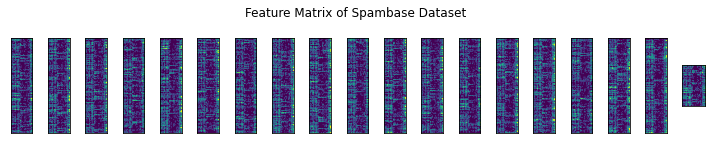

In [4]:
# visualize X matrix
fig, ax = plt.subplots(1, 19, figsize=(10, 2))
for i in range(19):
    ax[i].imshow(X[250*i:250*(i+1), :])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.suptitle("Feature Matrix of Spambase Dataset")
plt.tight_layout()
plt.savefig("spambase_features.png")
plt.show()

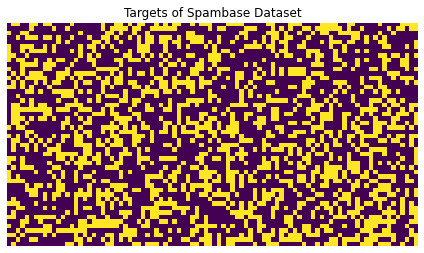

In [5]:
# visualize target vector
plt.imshow(y[:-1].reshape(50, -1))
plt.title("Targets of Spambase Dataset")
plt.axis("off")
plt.tight_layout()
plt.savefig("spambase_targets.png")
plt.show()

In [6]:
# construct train, test datasets
X_train, X_test = X[:2000, :], X[2000:, :]
y_train, y_test = y[:2000], y[2000:]

print(f"Training dimensions = {X_train.shape}, {y_train.shape}")
print(f"Testing dimensions = {X_test.shape}, {y_test.shape}")

Training dimensions = (2000, 57), (2000,)
Testing dimensions = (2601, 57), (2601,)


In [7]:
# train classifier with different n in training set
# save loss curves to check convergence
# save accuracy on test data as a function of n

losses = {n: 0 for n in [200, 500, 800, 1000, 1500, 2000]}
accuracies = {n: 0 for n in [200, 500, 800, 1000, 1500, 2000]}
models = {n: 0 for n in [200, 500, 800, 1000, 1500, 2000]}

for n in accuracies.keys():

    print(f"Training size = {n}")
    model = LogisticRegression(regularizer=None)
    model.fit(X_train[:n, :], y_train[:n])
    models[n] = model
    losses[n] = model.losses

    y_hat = model.predict(X_test)
    acc = accuracy_score(y_test, y_hat)
    print(f"\tAccuracy = {acc}")
    accuracies[n] = acc

Training size = 200
	[LogisticRegression] Constructed with None regularization and learning rate 0.1
	[LogisticRegression] Training with None regularization converged after 2058 iterations.
	Accuracy = 0.9034986543637062
Training size = 500
	[LogisticRegression] Constructed with None regularization and learning rate 0.1
	[LogisticRegression] Training with None regularization converged after 1517 iterations.
	Accuracy = 0.9296424452133795
Training size = 800
	[LogisticRegression] Constructed with None regularization and learning rate 0.1
	[LogisticRegression] Training with None regularization converged after 1383 iterations.
	Accuracy = 0.9350249903883122
Training size = 1000
	[LogisticRegression] Constructed with None regularization and learning rate 0.1
	[LogisticRegression] Training with None regularization converged after 1371 iterations.
	Accuracy = 0.9315647827758554
Training size = 1500
	[LogisticRegression] Constructed with None regularization and learning rate 0.1
	[LogisticReg

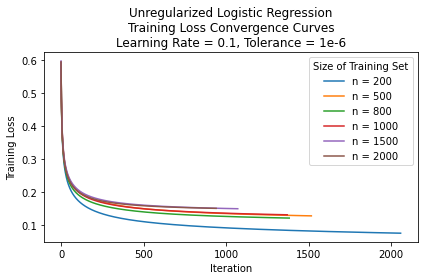

In [8]:
# visualize training loss curves
for n in losses.keys():
    plt.plot(losses[n], label=f"n = {n}")

plt.title("Unregularized Logistic Regression\n"
          "Training Loss Convergence Curves\n"
          "Learning Rate = 0.1, Tolerance = 1e-6")
plt.xlabel("Iteration")
plt.ylabel("Training Loss")
plt.legend(title="Size of Training Set")
plt.tight_layout()
plt.savefig("unregularized_convergence.png")
plt.show()

In [9]:
# examine test set performance by size of training set
df = pd.DataFrame(accuracies, index=["Accuracy"]).T
df.reset_index(inplace=True)
df.columns = ["n", "Accuracy"]
df

,n,Accuracy
0,200,0.903499
1,500,0.929642
2,800,0.935025
3,1000,0.931565
4,1500,0.938101
5,2000,0.939639


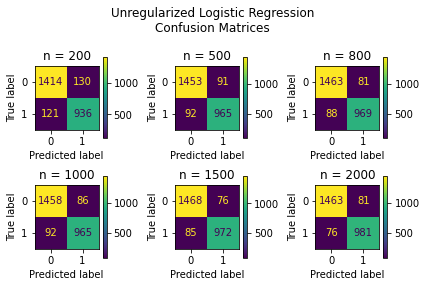

In [10]:
# plot confusion matrices
fig, ax = plt.subplots(2, 3, figsize=(6, 4))
ax = ax.flatten()

for i, (n, model) in enumerate(models.items()):
    y_hat = model.predict(X_test)
    confusion = confusion_matrix(y_test, y_hat)
    cmd = ConfusionMatrixDisplay(confusion)
    cmd.plot(ax=ax[i])
    ax[i].set_title(f"n = {n}")

plt.suptitle("Unregularized Logistic Regression\n"
             "Confusion Matrices")
plt.tight_layout()
plt.savefig("spambase_confusion.png")
plt.show()

#### Experiment 2: Sparse Logistic Regression

In [11]:
# load data
X_train = np.loadtxt("alzheimers_X_train.txt")
y_train = np.loadtxt("alzheimers_y_train.txt")
X_test = np.loadtxt("alzheimers_X_test.txt")
y_test = np.loadtxt("alzheimers_y_test.txt")

# recode y to {0, 1}
y_train = np.clip(y_train, 0, 1)
y_test = np.clip(y_test, 0, 1)

print(f"Training dimensions = {X_train.shape}, {y_train.shape}")
print(f"Testing dimensions = {X_test.shape}, {y_test.shape}")

Training dimensions = (172, 116), (172,)
Testing dimensions = (74, 116), (74,)


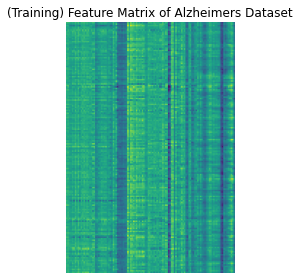

In [12]:
# visualize X_train matrix
plt.imshow(X_train)
plt.axis("off")
plt.title("(Training) Feature Matrix of Alzheimers Dataset")
plt.tight_layout()
plt.savefig("alzheimers_features.png")
plt.show()

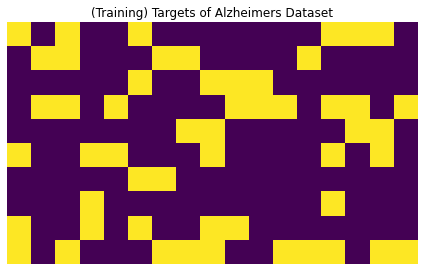

In [13]:
# visualize target vector
plt.imshow(y_train[:-2].reshape(10, -1))
plt.title("(Training) Targets of Alzheimers Dataset")
plt.axis("off")
plt.tight_layout()
plt.savefig("alzheimers_targets.png")
plt.show()

In [14]:
# train classifier with different regularization lambdas
# save loss curves to check convergence
# save accuracy on test data as a function of n
# save models for each lambda

lambdas = [i/100 for i in range(11)]
losses = {lam: 0 for lam in lambdas}
accuracies = {lam: 0 for lam in lambdas}
aucs = {lam: 0 for lam in lambdas}
models = {lam: None for lam in lambdas}

for lam in accuracies.keys():

    lr = 0.001 if lam > 0 else 0.1
    print(f"Lambda = {lam}")
    model = LogisticRegression(regularizer="l1", lam=lam, lr=lr, tol=1e-10)
    model.fit(X_train, y_train)
    models[lam] = model
    losses[lam] = model.losses

    print(f"\tNonzero Weights = {len(np.where(model.w > 1e-3)[0])}")

    y_hat = model.predict(X_test)
    acc = accuracy_score(y_test, y_hat)
    print(f"\tAccuracy = {acc}")
    accuracies[lam] = acc

    y_prob = model.predict_prob(X_test)
    auc = roc_auc_score(y_test, y_prob)
    print(f"\tAUC = {auc}")
    aucs[lam] = auc

Lambda = 0.0
	[LogisticRegression] Constructed with l1 regularization and learning rate 0.1
	[LogisticRegression] Training with l1 regularization terminated after 5000 iterations with delta 9.989042788322488e-07.
	Nonzero Weights = 55
	Accuracy = 0.6486486486486487
	AUC = 0.6440191387559808
Lambda = 0.01
	[LogisticRegression] Constructed with l1 regularization and learning rate 0.001
	[LogisticRegression] Training with l1 regularization terminated after 5000 iterations with delta 3.997086076838272e-08.
	Nonzero Weights = 22
	Accuracy = 0.6081081081081081
	AUC = 0.6497607655502393
Lambda = 0.02
	[LogisticRegression] Constructed with l1 regularization and learning rate 0.001
	[LogisticRegression] Training with l1 regularization terminated after 5000 iterations with delta 7.655207958930334e-08.
	Nonzero Weights = 15
	Accuracy = 0.581081081081081
	AUC = 0.6363636363636364
Lambda = 0.03
	[LogisticRegression] Constructed with l1 regularization and learning rate 0.001
	[LogisticRegression] Tr

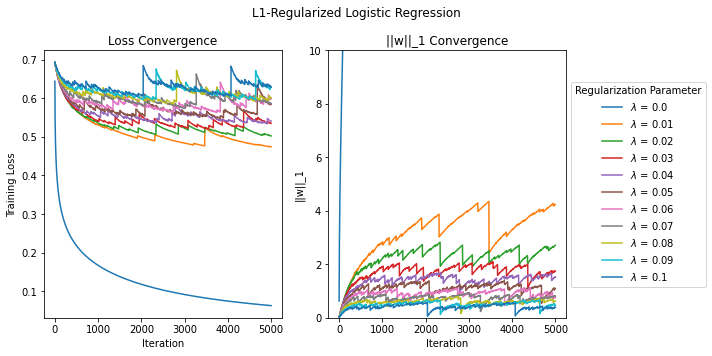

In [15]:
# visualize training loss curves alongside norm decrease curves to check convergence
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# plot losses
for lam in losses.keys():
    ax[0].plot(losses[lam], label=f"$\lambda$ = {lam}")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("Training Loss")
ax[0].set_title("Loss Convergence")

# plot weight norm curves
for lam in models.keys():
    ax[1].plot(models[lam].w_norms, label=f"$\lambda$ = {lam}")
ax[1].set_ylim((0, 10))
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("||w||_1")
ax[1].set_title("||w||_1 Convergence")

fig.suptitle("L1-Regularized Logistic Regression")
plt.legend(title="Regularization Parameter", loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig("l1_convergence.png")
plt.show()

In [16]:
# examine test set performance and norms
df = pd.DataFrame(accuracies, index=["Accuracy"]).T
df.reset_index(inplace=True)
df.columns = ["lambda", "Accuracy"]
df["AUC"] = list(aucs.values())
df["||w||_1"] = [np.sum(np.abs(model.w)) for model in models.values()]
df["n_nonzero"] = [len(np.where(model.w > 1e-3)[0]) for model in models.values()]
df

,lambda,Accuracy,AUC,||w||_1,n_nonzero
0,0.00,0.648649,0.644019,89.960670,55
1,0.01,0.608108,0.649761,4.234544,22
2,0.02,0.581081,0.636364,2.708845,15
3,0.03,0.594595,0.676555,1.748534,14
4,0.04,0.608108,0.678469,1.522523,8
5,0.05,0.648649,0.696651,1.092044,9
6,0.06,0.608108,0.720574,0.753853,8
7,0.07,0.608108,0.677512,0.813993,4
8,0.08,0.608108,0.649761,0.631632,5
9,0.09,0.594595,0.658373,0.474558,5


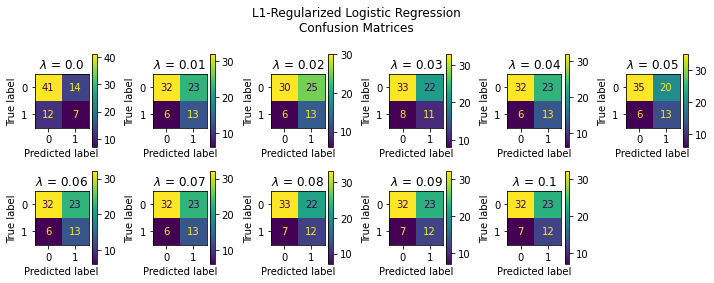

In [17]:
# plot confusion matrices
fig, ax = plt.subplots(2, 6, figsize=(10, 4))
ax = ax.flatten()

for i, (lam, model) in enumerate(models.items()):
    y_hat = model.predict(X_test)
    confusion = confusion_matrix(y_test, y_hat)
    cmd = ConfusionMatrixDisplay(confusion)
    cmd.plot(ax=ax[i])
    ax[i].set_title(f"$\lambda$ = {lam}")

plt.axis("off")
plt.suptitle("L1-Regularized Logistic Regression\n"
             "Confusion Matrices")
plt.tight_layout()
plt.savefig("l1_confusion.png")
plt.show()

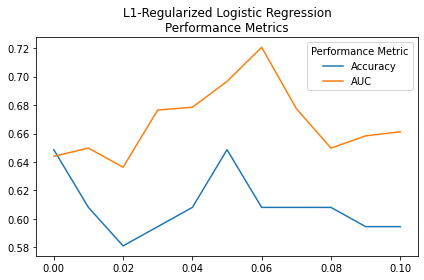

In [18]:
# plot AUC and accuracy by model
fig, ax = plt.subplots()
accuracy_path = list(accuracies.values())
auc_path = list(aucs.values())

plt.plot(lambdas, accuracy_path, label="Accuracy")
plt.plot(lambdas, auc_path, label="AUC")

plt.title("L1-Regularized Logistic Regression\n"
          "Performance Metrics")
plt.legend(title="Performance Metric")
plt.tight_layout()
plt.savefig("l1_performance.png")
plt.show()